<center>
    <h1> Machine Learning for Computer Vision</h1>
    <h2> Project Work </h2>
</center>

<br>

**Student**: Matteo Donati <br>
**Student ID**: 0001032227 <br>
**E-mail**: <a href="mailto:matteo.donati10@studio.unibo.it">matteo.donati10@studio.unibo.it</a>

<br>

This is an unofficial implementation of the paper by Guo et al., (2021)<sup>[[1]](#references)</sup>.

## Libraries

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms as T
import multiprocessing as mp
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report

In [2]:
def set_reproducibility(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

set_reproducibility(0)

## Data Loading and Preprocessing

In [3]:
# Retrieves the CIFAR10 dataset.
def get_cifar10(train_transform = None, test_transform = None):

  # Downloading the training set.
  train_dataset =  datasets.CIFAR10(
    root = "CIFAR10",
    train = True,
    transform = train_transform,
    download = True
  )

  # Downloading the test set.
  test_dataset = datasets.CIFAR10(
    root = "CIFAR10",
    train = False,
    transform = test_transform,
    download = True
  )

  # Returning the two sets.
  return train_dataset, test_dataset

# Fuction that creates train, validation and test data loaders.
def create_data_loaders(train_transform, 
                        test_transform, 
                        img_size = 224, 
                        split = (0.8, 0.2), 
                        batch_size = 32, 
                        num_workers = 1):

  # Retrieving CIFAR10.
  train_dataset, test_dataset = get_cifar10(train_transform, test_transform)

  # Splitting train_dataset to create a validation set.
  train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, 
                                                             (int(len(train_dataset) * split[0]), 
                                                              int(len(train_dataset) * split[1])))

  # Train data loader.
  train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers,
    pin_memory = True,
    drop_last = True,
    sampler = None
  )

  # Validation data loader.
  val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = num_workers,
    pin_memory = True,
    drop_last = False,
    sampler = None
  )

  # Test data loader.
  test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = num_workers,
    pin_memory = True,
    drop_last = False,
    sampler = None
  )

  # Returning the three data loaders.
  return train_loader, val_loader, test_loader

In [4]:
# Training transformations.
train_transform = T.Compose([
    T.RandomCrop(32, padding = 4),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean = [0.491, 0.482, 0.447], std = [0.247, 0.243, 0.262])
])

# Test transformations.
test_transform = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean = [0.491, 0.482, 0.447], std = [0.247, 0.243, 0.262])
])

# Creating data loaders.
train_loader, val_loader, test_loader = create_data_loaders(
    train_transform,
    test_transform,
    img_size = 224,
    batch_size = 32,
    num_workers = mp.cpu_count()
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10
Files already downloaded and verified


## Models Definition and Training

### Utilities

In [5]:
# Choosing between GPU and CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Stem module of the CMT architecture.
class Stem(nn.Module):
    
  # Constructor. Requires number of input and output channels.
  def __init__(self, in_channels, out_channels):

    super().__init__()

    # Conv 3 x 3, stride 2.
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1)
    self.bn1 = nn.BatchNorm2d(out_channels)

    # Conv 3 x 3. 
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
    self.bn2 = nn.BatchNorm2d(out_channels)

    # Conv 3 x 3.
    self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
    self.bn3 = nn.BatchNorm2d(out_channels)

    # GELU activation.
    self.gelu = nn.GELU()

  # Forward pass.
  def forward(self, x):
    x = self.conv1(x)
    x = self.gelu(x)
    x = self.bn1(x)
    x = self.conv2(x)
    x = self.gelu(x)
    x = self.bn2(x)
    x = self.conv3(x)
    x = self.gelu(x)
    y = self.bn3(x)
    return y

In [7]:
# Patch embedding module of the CMT architecture.
class PatchEmbedding(nn.Module):

  # Constructor. Requires number of input and output channels.
  def __init__(self, in_channels, out_channels):

    super().__init__()

    # Conv 2 x 2, stride 2.
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, stride = 2, padding = 0)

  # Forward pass.
  def forward(self, x):
    x = self.conv(x)
    _, c, h, w = x.size()
    y = torch.nn.functional.layer_norm(x, (c, h, w))
    return y

In [8]:
# Local Perception Unit: LPU(X) = DWConv(X) + X.
class LPU(nn.Module):

  # Constructor.
  def __init__(self, in_channels, out_channels):

    super().__init__()

    # Depthwise convolution.
    self.dwconv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, groups = in_channels)

  # Forward pass.
  def forward(self, x):
    y = self.dwconv(x) + x
    return y

In [9]:
# Lightweight Multi-Head-Self-Attention.
class LMHSA(nn.Module):
    
  # Constructor.
  def __init__(self, input_size, channels, d_k, d_v, stride, heads):

    super().__init__()

    # Depthwise convolutions.
    self.dwconv = nn.Conv2d(channels, channels, kernel_size = stride, stride = stride, groups = channels)

    # Projection matrices.
    self.fc_q = nn.Linear(channels, heads * d_k)
    self.fc_k = nn.Linear(channels, heads * d_k)
    self.fc_v = nn.Linear(channels, heads * d_v)
    self.fc_o = nn.Linear(heads * d_k, channels)

    self.channels = channels
    self.d_k = d_k
    self.d_v = d_v
    self.stride = stride
    self.heads = heads

    # Relative position bias to each self-attention module.
    self.B = nn.Parameter(torch.randn(1, self.heads, input_size ** 2, (input_size // stride) ** 2), requires_grad = True)
    
  # Forward pass.
  def forward(self, x):

    # Extracting shape from input signal.
    b, c, h, w = x.shape

    # Reshaping and permuting x. Final shape is (b, h * w, c).
    x_reshape = x.view(b, c, h * w).permute(0, 2, 1)

    # Layer norm.
    x_reshape = torch.nn.functional.layer_norm(x_reshape, (b, h * w, c))

    # Getting queries by applying the fc_q linear projection.
    q = self.fc_q(x_reshape)

    # Reshaping and permuting the queries. Final shape is (b, heads, n = h * w, d_k). 
    q = q.view(b, h * w, self.heads, self.d_k).permute(0, 2, 1, 3).contiguous()

    # Applying depthwise conv to x.
    k = self.dwconv(x)

    # Extracting shape of keys.
    k_b, k_c, k_h, k_w = k.shape

    # Reshaping and permuting keys. Final shape is (k_b, k_h * k_w, k_c).
    k = k.view(k_b, k_c, k_h * k_w).permute(0, 2, 1).contiguous()

    # Projecting through fc_k.
    k = self.fc_k(k)

    # Reshaping and permuting the keys. Final shape is (k_b, heads, k_h * k_w, d_k).
    k = k.view(k_b, k_h * k_w, self.heads, self.d_k).permute(0, 2, 1, 3).contiguous()

    # Applying depthwise conv to x.
    v = self.dwconv(x)

    # Extracting shape of values.
    v_b, v_c, v_h, v_w = v.shape

    # Reshaping and permuting values. Final shape is (v_b, v_h * v_w, v_c).
    v = v.view(v_b, v_c, v_h * v_w).permute(0, 2, 1).contiguous()

    # Projecting through fc_v.
    v = self.fc_v(v)

    # Reshaping and permuting the keys. Final shape is (v_b, heads, v_h * v_w, d_v).
    v = v.view(v_b, v_h * v_w, self.heads, self.d_v).permute(0, 2, 1, 3).contiguous()

    # Computing softmax((Q K') / sqrt(d_k) + B). Final shape is (b, heads, n = h * w, k_h * k_w).
    attention = torch.einsum("... i d, ... j d -> ... i j", q, k) * (self.d_k ** -0.5)
    attention = attention + self.B
    attention = torch.softmax(attention, dim = -1)

    # Applying attention scores to values by taking the dot product.
    tmp = torch.matmul(attention, v).permute(0, 2, 1, 3)

    # Permuting the result. Final shape is (b, n = h * w, heads, d_v).
    tmp = tmp.contiguous().view(b, h * w, self.heads * self.d_v)

    # Projecting using fc_o and reshaping. Final shape is (b, c, h, w).
    tmp = self.fc_o(tmp).view(b, self.channels, h, w)

    # Returning tmp + x (skip connection).
    return tmp + x

In [10]:
# Standard Multi-Head-Self-Attention.
class MHSA(nn.Module):
    
  # Constructor.
  def __init__(self, input_size, channels, d_k, d_v, stride, heads):

    super().__init__()

    # Projection matrices.
    self.fc_q = nn.Linear(channels, heads * d_k)
    self.fc_k = nn.Linear(channels, heads * d_k)
    self.fc_v = nn.Linear(channels, heads * d_v)
    self.fc_o = nn.Linear(heads * d_k, channels)

    self.channels = channels
    self.d_k = d_k
    self.d_v = d_v
    self.stride = stride
    self.heads = heads
    
  # Forward pass.
  def forward(self, x):

    # Extracting shape from input signal.
    b, c, h, w = x.shape

    # Reshaping and permuting x. Final shape is (b, h * w, c).
    x_reshape = x.view(b, c, h * w).permute(0, 2, 1)

    # Layer norm.
    x_reshape = torch.nn.functional.layer_norm(x_reshape, (b, h * w, c))

    # Getting queries by applying the fc_q linear projection.
    q = self.fc_q(x_reshape)

    # Reshaping and permuting the queries. Final shape is (b, heads, n = h * w, d_k). 
    q = q.view(b, h * w, self.heads, self.d_k).permute(0, 2, 1, 3).contiguous()

    # Projecting through fc_k.
    k = self.fc_k(x_reshape)

    # Reshaping and permuting the keys. Final shape is (b, heads, h * w, d_k).
    k = k.view(b, h * w, self.heads, self.d_k).permute(0, 2, 1, 3).contiguous()

    # Projecting through fc_v.
    v = self.fc_v(x_reshape)

    # Reshaping and permuting the keys. Final shape is (b, heads, h * w, d_v).
    v = v.view(b, h * w, self.heads, self.d_v).permute(0, 2, 1, 3).contiguous()

    # Computing softmax((Q K) / sqrt(d_k)).
    attention = torch.einsum("... i d, ... j d -> ... i j", q, k) * (self.d_k ** -0.5)
    attention = torch.softmax(attention, dim = -1)

    # Applying attention scores to values by taking the dot product.
    tmp = torch.matmul(attention, v).permute(0, 2, 1, 3)

    # Permuting the result. Final shape is (b, n = h * w, heads, d_v).
    tmp = tmp.contiguous().view(b, h * w, self.heads * self.d_v)

    # Projecting using fc_o and reshaping. Final shape is (b, c, h, w).
    tmp = self.fc_o(tmp).view(b, self.channels, h, w)

    # Returning tmp + x (skip connection).
    return tmp + x

In [11]:
# Inverted Residual Feed-forward Network: IRFFN(X) = Conv(F(Conv(X))), F(X) = DWConv(X) + X.
class IRFFN(nn.Module):

  # Constructor.
  def __init__(self, in_channels, R):

    super().__init__()

    # Number of channels after expansion.
    out_channels = int(in_channels * R)

    # Conv 1 x 1.
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1)
    self.bn1 = nn.BatchNorm2d(out_channels)

    # Depthwise convolution.
    self.dwconv = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, groups = out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)

    # Conv 1 x 1.
    self.conv2 = nn.Conv2d(out_channels, in_channels, kernel_size = 1)
    self.bn3 = nn.BatchNorm2d(in_channels)

    # GELU activation.
    self.gelu = nn.GELU()

  # Forward pass.
  def forward(self, x):
    tmp = self.conv1(x)
    tmp = self.bn1(tmp)
    tmp = self.gelu(tmp)
    tmp = self.dwconv(tmp)
    tmp = self.bn2(tmp)
    tmp = self.gelu(tmp)
    tmp = self.conv2(tmp)
    tmp = self.bn3(tmp)
    y = x + tmp
    return y

In [12]:
# CMT block of the CMT architecture.
class CMTBlock(nn.Module):

  # Constructor. By default it loads the CMT-Ti configuration.
  def __init__(self, img_size, k, d_k, d_v, num_heads, R = 3.6, in_channels = 46, attention_type = "light"):

    super().__init__()

    # Local Perception Unit.
    self.lpu = LPU(in_channels, in_channels)

    # Lightweight MHSA.
    if attention_type == "light":
      self.mhsa = LMHSA(img_size, in_channels, d_k, d_v, k, num_heads)
    
    # Lightweight MHSA.
    elif attention_type == "standard":
      self.mhsa = MHSA(img_size, in_channels, d_k, d_v, k, num_heads)
    
    # No attention.
    else:
      self.mhsa = None

    # Inverted Residual FFN.
    self.irffn = IRFFN(in_channels, R)

  # Forward pass.
  def forward(self, x):
    x = self.lpu(x)
    if self.mhsa != None: x = self.mhsa(x)
    y = self.irffn(x)
    return y

In [13]:
# CMT architecture.
class CMT(nn.Module):

  # Constructor. By default it loads the CMT-Ti configuration.
  def __init__(self,
    in_channels = 3,
    stem_channels = 16,
    cmt_channels = [46, 92, 184, 368],
    patch_channels = [46, 92, 184, 368],
    block_layers = [2, 2, 10, 2],
    R = 3.6,
    img_size = 224,
    num_class = 10,
    attention_type = "light"
  ):

    super(CMT, self).__init__()

    # Stem layer
    self.stem = Stem(in_channels, stem_channels)

    # Patch Aggregation Layer
    self.pe1 = PatchEmbedding(stem_channels, patch_channels[0])
    self.pe2 = PatchEmbedding(patch_channels[0], patch_channels[1])
    self.pe3 = PatchEmbedding(patch_channels[1], patch_channels[2])
    self.pe4 = PatchEmbedding(patch_channels[2], patch_channels[3])

    # Stage 1 CMT blocks.
    stage1 = [CMTBlock(img_size = img_size // 4, 
                       k = 8, 
                       d_k = cmt_channels[0], 
                       d_v = cmt_channels[0], 
                       num_heads = 1, 
                       R = R, 
                       in_channels = patch_channels[0],
                       attention_type = attention_type) for _ in range(block_layers[0])]
    self.stage1 = nn.Sequential(*stage1)

    # Stage 2 CMT blocks.
    stage2 = [CMTBlock(img_size = img_size // 8,
                       k = 4,
                       d_k = cmt_channels[1] // 2,
                       d_v = cmt_channels[1] // 2,
                       num_heads = 2,
                       R = R,
                       in_channels = patch_channels[1],
                       attention_type = attention_type) for _ in range(block_layers[1])]
    self.stage2 = nn.Sequential(*stage2)

    # Stage 3 CMT blocks.
    stage3 = [CMTBlock(img_size = img_size // 16,
                       k = 2,
                       d_k = cmt_channels[2] // 4,
                       d_v = cmt_channels[2] // 4,
                       num_heads = 4,
                       R = R,
                       in_channels = patch_channels[2],
                       attention_type = attention_type) for _ in range(block_layers[2])]
    self.stage3 = nn.Sequential(*stage3)

    # Stage 4 CMT blocks.
    stage4 = [CMTBlock(img_size = img_size // 32,
                       k = 1,
                       d_k = cmt_channels[3] // 8,
                       d_v = cmt_channels[3] // 8,
                       num_heads = 8,
                       R = R,
                       in_channels = patch_channels[3],
                       attention_type = attention_type) for _ in range(block_layers[3])]
    self.stage4 = nn.Sequential(*stage4)

    # Global average pooling.
    self.avg_pool = nn.AdaptiveAvgPool2d(1)

    # Projection layer.
    self.projection = nn.Sequential(
      nn.Conv2d(cmt_channels[3], 1280, kernel_size = 1),
      nn.ReLU(inplace = True),
    )

    # Classifier.
    self.classifier = nn.Linear(1280, num_class)

  # Forward pass.
  def forward(self, x):
    x = self.stem(x)
    x = self.pe1(x)
    x = self.stage1(x)
    x = self.pe2(x)
    x = self.stage2(x)
    x = self.pe3(x)
    x = self.stage3(x)
    x = self.pe4(x)
    x = self.stage4(x)
    x = self.avg_pool(x)
    x = self.projection(x)
    x = torch.flatten(x, 1)
    y = self.classifier(x)
    return y

In [14]:
# Trains the model.
def train(model, optimizer, scheduler, loss_fn, train_loader, val_loader, epochs, device = "cuda", history = None):

  # Metrics.
  if history == None: 
    history = {"train_loss": [], "train_accuracy": [], "val_loss": [], "val_accuracy": [], "lr": []}

  # Iterating over epochs.
  for epoch in range(epochs):

    print("Epoch %2d/%2d:" % (epoch + 1, epochs))

    # Training.
    model.train()

    # Metrics
    train_loss = 0.0
    num_train_correct = 0
    num_train_examples = 0

    # Iterating over mini-batches.
    for batch in tqdm(train_loader, desc = "Training", position = 0):

      # Gradient reset.
      optimizer.zero_grad()

      # Moving x and y to GPU.
      x = batch[0].to(device)
      y = batch[1].to(device)

      # Predictions.
      yhat = model(x)

      # Loss.
      loss = loss_fn(yhat, y)

      # Computing the gradient.
      loss.backward()

      # Updating the parameters.
      optimizer.step()

      # Updating the metrics.
      train_loss += loss.item() * x.shape[0]
      num_train_correct += (torch.argmax(yhat, 1) == y).sum().item()
      num_train_examples += x.shape[0]

    # Computing the epoch's metrics.
    train_accuracy = num_train_correct / num_train_examples
    train_loss = train_loss / len(train_loader.dataset)

    # Saving learning rate.
    lr = scheduler.get_last_lr()[0]

    # Updating the learning rate.
    scheduler.step()

    # Validation.
    model.eval()

    # Metrics.
    val_loss = 0.0
    num_val_correct = 0
    num_val_examples = 0

    with torch.no_grad():

      # Iterating over mini-batches.
      for batch in tqdm(val_loader, desc = "Validation", position = 0):

        # Moving x and y to GPU.
        x = batch[0].to(device)
        y = batch[1].to(device)

        # Predictions.
        yhat = model(x)

        # Loss.
        loss = loss_fn(yhat, y)

        # Updating the metrics.
        val_loss += loss.item() * x.shape[0]
        num_val_correct += (torch.argmax(yhat, 1) == y).sum().item()
        num_val_examples += y.shape[0]

      # Computing the epoch's metrics.
      val_accuracy = num_val_correct / num_val_examples
      val_loss = val_loss / len(val_loader.dataset)

    print("{}train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}, lr: {:.4e}{}".format("\n" if epoch == epochs - 1 else "",
                                                                                                                      train_loss, 
                                                                                                                      train_accuracy, 
                                                                                                                      val_loss, 
                                                                                                                      val_accuracy,
                                                                                                                      lr,
                                                                                                                      "\n" if epoch != epochs - 1 else ""))

    # Appending the epoch's metrics to history lists.
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_accuracy"].append(train_accuracy)
    history["val_accuracy"].append(val_accuracy)
    history["lr"].append(lr)

  # Returning history.
  return history

In [15]:
# Plots losses and accuracies.
def plot_training(history):

  # Computing the x axis array.
  x = np.linspace(1, len(history["train_loss"]), len(history["train_loss"]), dtype = int)

  # Creating the figure and axes.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 4))

  # Plotting losses.
  ax1.plot(x, history["train_loss"])
  ax1.plot(x, history["val_loss"])

  ax1.set_ylabel("Loss")
  ax1.set_xlabel("Epoch")
  ax1.set_xticks(x)
  ax1.legend(["Training", "Testing"])

  # Plotting accuracies.
  ax2.plot(x, history["train_accuracy"])
  ax2.plot(x, history["val_accuracy"])

  ax2.set_ylabel("Accuracy")
  ax2.set_xlabel("Epoch")
  ax2.set_xticks(x)
  ax2.legend(["Training", "Testing"])

  plt.show()

In [16]:
# Tests a model.
def test(model, test_loader):
  
  # Tetsing.
  model.eval()

  # Predictions and ground truth.
  y_pred = []
  y_true = []

  with torch.no_grad():

    # Iterating over mini-batches.
    for batch in tqdm(test_loader, desc = "Testing", position = 0):

      # Moving x and y to GPU.
      x = batch[0].to(device)
      y = batch[1].to(device)

      # Predictions.
      yhat = model(x)

      # Updating variables.
      y_pred.extend(torch.argmax(yhat, 1).tolist())
      y_true.extend(y.tolist())

  # Returning pred and true.
  return y_pred, y_true

In [17]:
# Loads a checkpoint.
def load_checkpoint(path, model, optimizer, scheduler):

  # Loading checkpoint.
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint["model"])
  optimizer.load_state_dict(checkpoint["optimizer"])
  scheduler.load_state_dict(checkpoint["scheduler"])

  # Returning checkpoint entries.
  return model, optimizer, scheduler, checkpoint["history"]

### Lightweight MHSA model ($m_1$)

In [18]:
# Defining the model that uses LMHSA.
m_1 = CMT(
  in_channels = 3,
  stem_channels = 16,
  cmt_channels = [46, 92, 184, 368],
  patch_channels = [46, 92, 184, 368],
  block_layers = [2, 2, 10, 2],
  R = 3.6,
  img_size = 224,
  num_class = 10,
  attention_type = "light")

# Printing number of parameters.
print(f"m_1 has {sum(p.numel() for p in m_1.parameters())} parameters.")

m_1 has 9014696 parameters.


In [19]:
# Loading model to device.
m_1.to(device)

CMT(
  (stem): Stem(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (gelu): GELU(approximate='none')
  )
  (pe1): PatchEmbedding(
    (conv): Conv2d(16, 46, kernel_size=(2, 2), stride=(2, 2))
  )
  (pe2): PatchEmbedding(
    (conv): Conv2d(46, 92, kernel_size=(2, 2), stride=(2, 2))
  )
  (pe3): PatchEmbedding(
    (conv): Conv2d(92, 184, kernel_size=(2, 2), stride=(2, 2))
  )
  (pe4): PatchEmbedding(
    (conv): Conv2d(184, 368, kernel_size=(2, 2), stride=(2, 2))
  )
  (stage1): Sequential(
    (0): CMTBlock(
      (lpu): LPU(
 

In [20]:
# Epochs.
EPOCHS = 25

# Initial learning rate.
LR = 6e-5

# Weight decay.
WD = 1e-5

# Loss function.
loss_fn = nn.CrossEntropyLoss()

# Optimizer.
optimizer = torch.optim.AdamW(m_1.parameters(), lr = LR, weight_decay = WD)

# Scheduler.
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

In [21]:
# Training.
history = train(m_1, optimizer, scheduler, loss_fn, train_loader, val_loader, EPOCHS, device)

# Creating a checkpoint.
checkpoint = {
  "history": history,
  "model": m_1.state_dict(),
  "optimizer": optimizer.state_dict(),
  "scheduler": scheduler.state_dict()
}

# Saving the model.
torch.save(checkpoint, "checkpoint1.pt")

Epoch  1/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.67it/s]


train_loss: 1.4419, train_accuracy: 0.4693, val_loss: 1.1494, val_accuracy: 0.5843, lr: 6.0000e-05

Epoch  2/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.65it/s]


train_loss: 1.0438, train_accuracy: 0.6272, val_loss: 0.9299, val_accuracy: 0.6743, lr: 5.9763e-05

Epoch  3/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.64it/s]


train_loss: 0.8683, train_accuracy: 0.6926, val_loss: 0.8188, val_accuracy: 0.7166, lr: 5.9057e-05

Epoch  4/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.66it/s]


train_loss: 0.7362, train_accuracy: 0.7399, val_loss: 0.6910, val_accuracy: 0.7509, lr: 5.7893e-05

Epoch  5/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.67it/s]


train_loss: 0.6461, train_accuracy: 0.7729, val_loss: 0.6498, val_accuracy: 0.7783, lr: 5.6289e-05

Epoch  6/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.67it/s]


train_loss: 0.5720, train_accuracy: 0.8007, val_loss: 0.5892, val_accuracy: 0.7938, lr: 5.4271e-05

Epoch  7/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.63it/s]


train_loss: 0.5209, train_accuracy: 0.8195, val_loss: 0.5647, val_accuracy: 0.8024, lr: 5.1869e-05

Epoch  8/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.63it/s]


train_loss: 0.4774, train_accuracy: 0.8351, val_loss: 0.5312, val_accuracy: 0.8157, lr: 4.9123e-05

Epoch  9/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.64it/s]


train_loss: 0.4326, train_accuracy: 0.8493, val_loss: 0.5117, val_accuracy: 0.8228, lr: 4.6075e-05

Epoch 10/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.68it/s]


train_loss: 0.4019, train_accuracy: 0.8584, val_loss: 0.4925, val_accuracy: 0.8333, lr: 4.2773e-05

Epoch 11/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.67it/s]


train_loss: 0.3702, train_accuracy: 0.8712, val_loss: 0.4606, val_accuracy: 0.8375, lr: 3.9271e-05

Epoch 12/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.68it/s]


train_loss: 0.3387, train_accuracy: 0.8825, val_loss: 0.4659, val_accuracy: 0.8401, lr: 3.5621e-05

Epoch 13/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.67it/s]


train_loss: 0.3109, train_accuracy: 0.8916, val_loss: 0.4557, val_accuracy: 0.8450, lr: 3.1884e-05

Epoch 14/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.68it/s]


train_loss: 0.2853, train_accuracy: 0.8992, val_loss: 0.4529, val_accuracy: 0.8478, lr: 2.8116e-05

Epoch 15/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.67it/s]


train_loss: 0.2636, train_accuracy: 0.9081, val_loss: 0.4407, val_accuracy: 0.8553, lr: 2.4379e-05

Epoch 16/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.67it/s]


train_loss: 0.2443, train_accuracy: 0.9149, val_loss: 0.4151, val_accuracy: 0.8627, lr: 2.0729e-05

Epoch 17/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.67it/s]


train_loss: 0.2251, train_accuracy: 0.9211, val_loss: 0.4174, val_accuracy: 0.8619, lr: 1.7227e-05

Epoch 18/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.68it/s]


train_loss: 0.2098, train_accuracy: 0.9258, val_loss: 0.4249, val_accuracy: 0.8623, lr: 1.3925e-05

Epoch 19/25:


Validation: 100%|██████████| 313/313 [00:35<00:00,  8.70it/s]


train_loss: 0.1927, train_accuracy: 0.9326, val_loss: 0.4107, val_accuracy: 0.8699, lr: 1.0877e-05

Epoch 20/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.68it/s]


train_loss: 0.1849, train_accuracy: 0.9358, val_loss: 0.4029, val_accuracy: 0.8702, lr: 8.1309e-06

Epoch 21/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.68it/s]


train_loss: 0.1721, train_accuracy: 0.9399, val_loss: 0.4005, val_accuracy: 0.8723, lr: 5.7295e-06

Epoch 22/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.67it/s]


train_loss: 0.1648, train_accuracy: 0.9428, val_loss: 0.3990, val_accuracy: 0.8715, lr: 3.7108e-06

Epoch 23/25:


Validation: 100%|██████████| 313/313 [00:35<00:00,  8.70it/s]


train_loss: 0.1621, train_accuracy: 0.9444, val_loss: 0.3982, val_accuracy: 0.8705, lr: 2.1067e-06

Epoch 24/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.65it/s]


train_loss: 0.1569, train_accuracy: 0.9467, val_loss: 0.3990, val_accuracy: 0.8723, lr: 9.4251e-07

Epoch 25/25:


Validation: 100%|██████████| 313/313 [00:36<00:00,  8.67it/s]



train_loss: 0.1552, train_accuracy: 0.9464, val_loss: 0.3920, val_accuracy: 0.8744, lr: 2.3656e-07


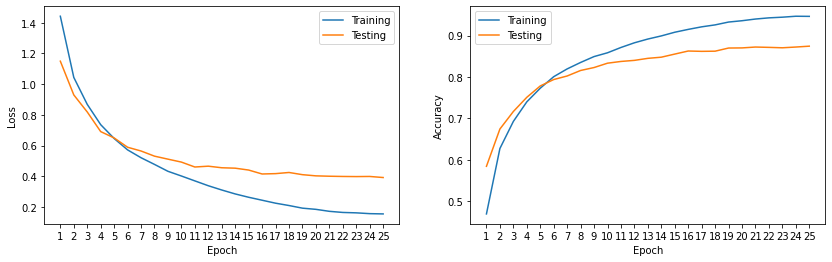

In [22]:
# Plotting losses and accuracies.
plot_training(history)

### Standard MHSA model ($m_2$)

In [ ]:
# Defining the model that uses standard MHSA.
m_2 = CMT(
  in_channels = 3,
  stem_channels = 16,
  cmt_channels = [46, 92, 184, 368],
  patch_channels = [46, 92, 184, 368],
  block_layers = [2, 2, 10, 2],
  R = 3.6,
  img_size = 224,
  num_class = 10,
  attention_type = "standard")

# Printing number of parameters.
print(f"m_2 has {sum(p.numel() for p in m_2.parameters())} parameters.")

In [ ]:
# Loading model to device.
m_2.to(device)

In [ ]:
# Epochs.
EPOCHS = 25

# Initial learning rate.
LR = 6e-5

# Weight decay.
WD = 1e-5

# Loss function.
loss_fn = nn.CrossEntropyLoss()

# Optimizer.
optimizer = torch.optim.AdamW(m_2.parameters(), lr = LR, weight_decay = WD)

# Scheduler.
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

In [ ]:
# Training.
history = train(m_2, optimizer, scheduler, loss_fn, train_loader, val_loader, EPOCHS, device)

# Creating a checkpoint.
checkpoint = {
  "history": history,
  "model": m_2.state_dict(),
  "optimizer": optimizer.state_dict(),
  "scheduler": scheduler.state_dict()
}

# Saving the model.
torch.save(checkpoint, "checkpoint2.pt")

In [ ]:
# Plotting losses and accuracies.
plot_training(history)

### No attention model ($m_3$)

In [ ]:
# Defining the model that does not use attention.
m_3 = CMT(
  in_channels = 3,
  stem_channels = 16,
  cmt_channels = [46, 92, 184, 368],
  patch_channels = [46, 92, 184, 368],
  block_layers = [2, 2, 10, 2],
  R = 3.6,
  img_size = 224,
  num_class = 10,
  attention_type = None)

# Printing number of parameters.
print(f"m_3 has {sum(p.numel() for p in m_3.parameters())} parameters.")

In [ ]:
# Loading model to device.
m_3.to(device)

In [ ]:
# Epochs.
EPOCHS = 25

# Initial learning rate.
LR = 6e-5

# Weight decay.
WD = 1e-5

# Loss function.
loss_fn = nn.CrossEntropyLoss()

# Optimizer.
optimizer = torch.optim.AdamW(m_3.parameters(), lr = LR, weight_decay = WD)

# Scheduler.
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

In [ ]:
# Training.
history = train(m_3, optimizer, scheduler, loss_fn, train_loader, val_loader, EPOCHS, device)

# Creating a checkpoint.
checkpoint = {
  "history": history,
  "model": m_3.state_dict(),
  "optimizer": optimizer.state_dict(),
  "scheduler": scheduler.state_dict()
}

# Saving the model.
torch.save(checkpoint, "checkpoint3.pt")

In [ ]:
# Plotting losses and accuracies.
plot_training(history)

## Models Testing

### Lightweight MHSA model ($m_1$)

In [23]:
# Testing the model.
y_pred, y_true = test(m_1, test_loader)

Testing: 100%|██████████| 313/313 [00:35<00:00,  8.71it/s]


In [24]:
# Classification report.
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1000
           1       0.96      0.94      0.95      1000
           2       0.86      0.84      0.85      1000
           3       0.76      0.77      0.76      1000
           4       0.86      0.89      0.88      1000
           5       0.82      0.82      0.82      1000
           6       0.92      0.92      0.92      1000
           7       0.95      0.91      0.93      1000
           8       0.93      0.94      0.94      1000
           9       0.93      0.93      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



### Standard MHSA model ($m_2$)

In [ ]:
# Testing the model.
y_pred, y_true = test(m_2, test_loader)

In [ ]:
# Classification report.
print(classification_report(y_true, y_pred))

### No attention model ($m_3$) 

In [ ]:
# Testing the model.
y_pred, y_true = test(m_3, test_loader)

In [ ]:
# Classification report.
print(classification_report(y_true, y_pred))

## References <a name="references"></a>

1. Jianyuan Guo, Kai Han, Han Wu, Chang Xu, Yehui Tang, Chunjing Xu and Yunhe Wang. CMT: Convolutional Neural Networks Meet Vision Transformers, 2021. [https://arxiv.org/abs/2107.06263](https://arxiv.org/abs/2107.06263).